##import library

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout,Flatten, Conv2D ,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Correct the spelling of confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report

##load dataset


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Unzip the dataset
!unzip -q "/content/drive/MyDrive/eye-classification.zip"

In [4]:
data_dir = 'dataset'

file_path = []
labels = []

folds = os.listdir(data_dir)
# folds
for fold in folds:
    fold_path = os.path.join(data_dir, fold)
    files = os.listdir(fold_path)
    for file in files:
        file_paths = os.path.join(fold_path, file)
        file_path.append(file_paths)
        labels.append(fold)

df = pd.DataFrame({'filepaths':file_path, 'labels':labels})
df

,filepaths,labels
0,dataset/cataract/2204_left.jpg,cataract
1,dataset/cataract/_270_58393.jpg,cataract
2,dataset/cataract/2169_right.jpg,cataract
3,dataset/cataract/_8_7059542.jpg,cataract
4,dataset/cataract/_230_9762004.jpg,cataract
...,...,...
4212,dataset/diabetic_retinopathy/10457_left.jpeg,diabetic_retinopathy
4213,dataset/diabetic_retinopathy/11542_left.jpeg,diabetic_retinopathy
4214,dataset/diabetic_retinopathy/129_left.jpeg,diabetic_retinopathy
4215,dataset/diabetic_retinopathy/10059_right.jpeg,diabetic_retinopathy


In [5]:
train_df, dummy_df = train_test_split(df,test_size=0.2, random_state=42)

In [6]:
val_df, test_df = train_test_split(dummy_df,test_size=0.5, random_state=42)


In [7]:
tr_gen = ImageDataGenerator(rotation_range=45,horizontal_flip=True)

ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels',target_size=(224,224),color_mode='rgb',class_mode='categorical',batch_size=16)
test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',target_size=(224,224),color_mode='rgb',class_mode='categorical',batch_size=8)
val_gen = ts_gen.flow_from_dataframe(val_df, x_col='filepaths', y_col='labels',target_size=(224,224),color_mode='rgb',class_mode='categorical',batch_size=8)

Found 3373 validated image filenames belonging to 4 classes.
Found 422 validated image filenames belonging to 4 classes.
Found 422 validated image filenames belonging to 4 classes.


In [8]:
train_gen.class_indices


{'cataract': 0, 'diabetic_retinopathy': 1, 'glaucoma': 2, 'normal': 3}

16


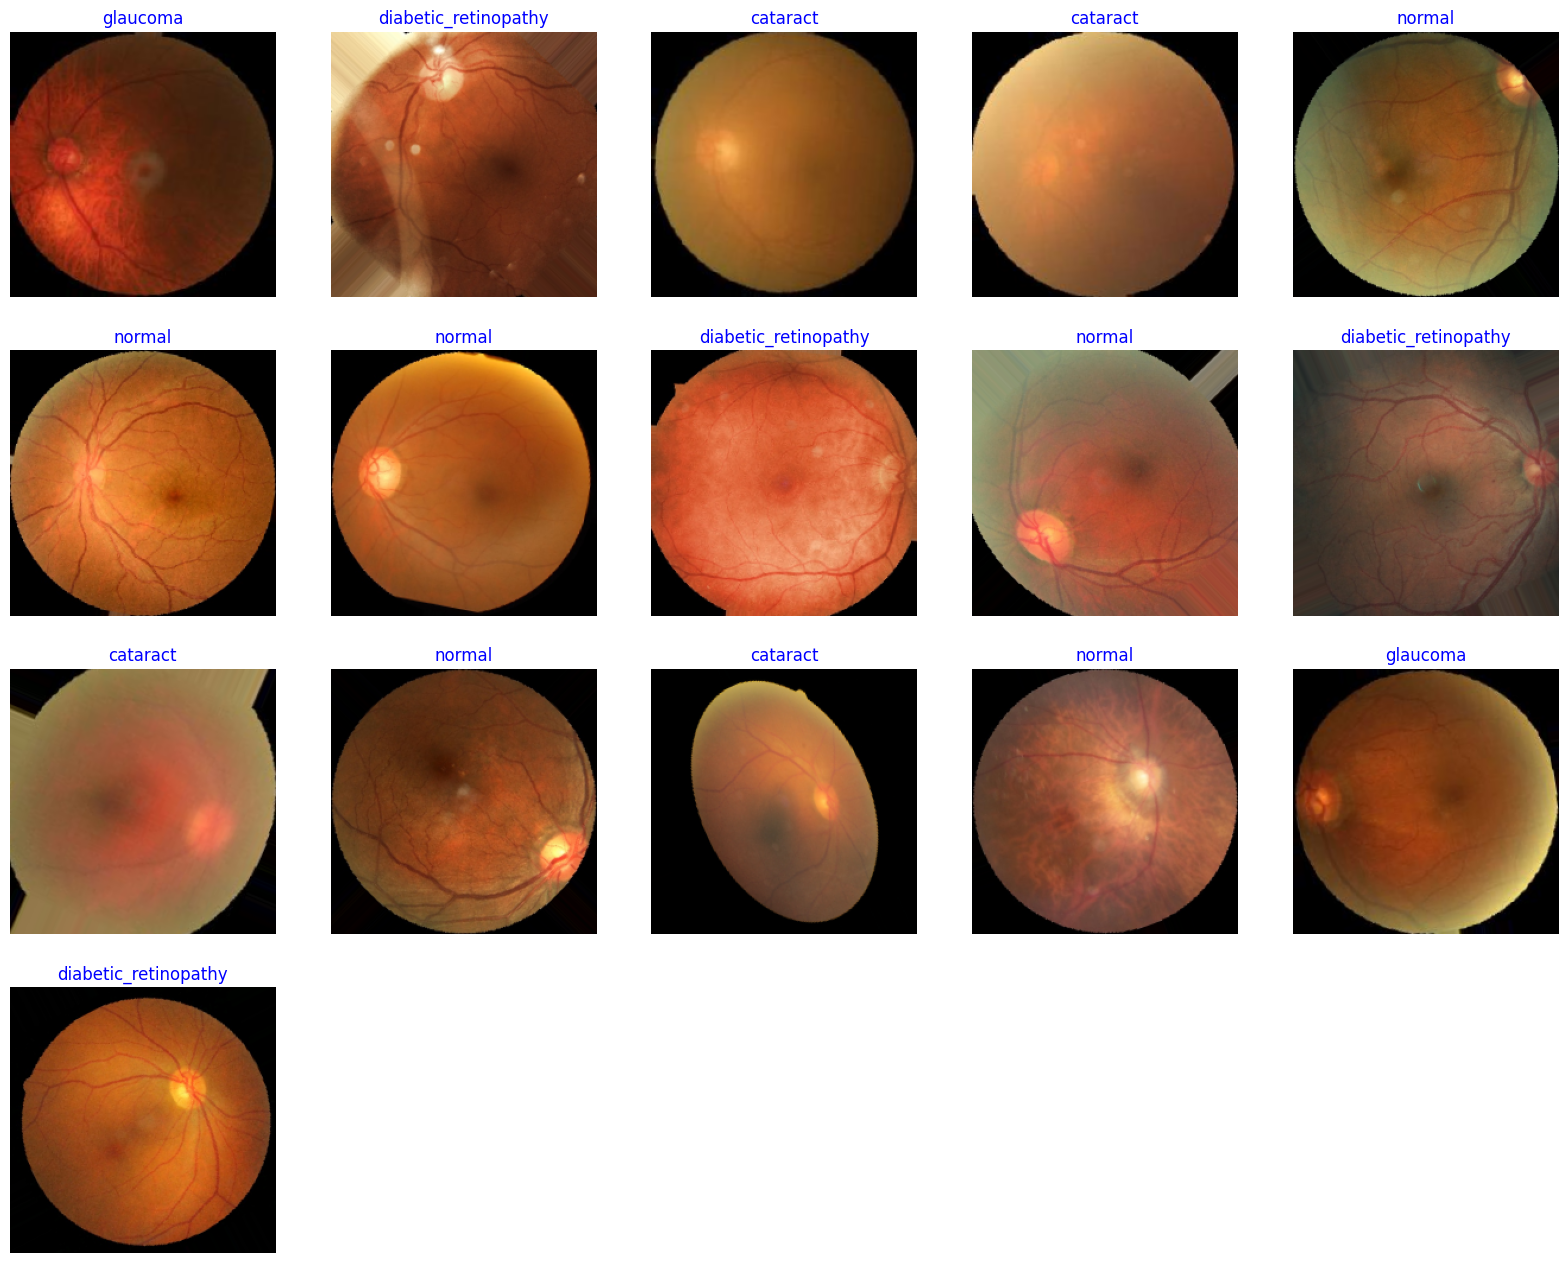

In [9]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)

length = len(labels)
print(length)
sample = min(length,24)

plt.figure(figsize=(20,20))

for i in range(sample):
    plt.subplot(5,5,i + 1)
    plt.imshow(images[i]/255)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name,color='blue',fontsize=12)
    plt.axis('off')
plt.show()


In [10]:
base_model = tf.keras.applications.EfficientNetB3(include_top=False,pooling='max',input_shape=(224,224,3))
model = Sequential([
    base_model,

    Dense(units=64, activation='relu'),
    Dense(units=16, activation='relu'),
    Dense(units=4, activation='softmax')
])

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 1536)           │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        98,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,883,011 (41.52 MB)

 Trainable params: 10,795,708 (41.18 MB)

 Non-trainable params: 87,303 (341.03 KB)

In [12]:
model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy', metrics=['accuracy'])


In [13]:
history = model.fit(train_gen, validation_data=val_gen, epochs=20)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 290s 781ms/step - accuracy: 0.6347 - loss: 1.2107 - val_accuracy: 0.8104 - val_loss: 0.6515
Epoch 2/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 67s 318ms/step - accuracy: 0.8335 - loss: 0.4451 - val_accuracy: 0.8626 - val_loss: 0.4395
Epoch 3/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 66s 312ms/step - accuracy: 0.8718 - loss: 0.3629 - val_accuracy: 0.9052 - val_loss: 0.3384
Epoch 4/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 66s 313ms/step - accuracy: 0.8948 - loss: 0.2904 - val_accuracy: 0.9171 - val_loss: 0.2453
Epoch 5/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 68s 320ms/step - accuracy: 0.9048 - loss: 0.2832 - val_accuracy: 0.9100 - val_loss: 0.2653
Epoch 6/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 66s 314ms/step - accuracy: 0.8960 - loss: 0.3143 - val_accuracy: 0.8791 - val_loss: 0.3372
Epoch 7/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 66s 314ms/step - accuracy: 0.9010 - loss: 0.2443 - val_accuracy: 0.9100 - val_loss: 0.2604
Epoch 8/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 66s 313ms/step - accuracy: 0.9188 - loss: 

In [14]:
# 6. Evaluate (Contoh sederhada)
loss, accuracy = model.evaluate(test_gen, steps=test_gen.samples)
print('Test accuracy :', accuracy)

model.summary()

422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9350 - loss: 0.2655  
Test accuracy : 0.9336493015289307


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 1536)           │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        98,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,474,429 (123.88 MB)

 Trainable params: 10,795,708 (41.18 MB)

 Non-trainable params: 87,303 (341.03 KB)

 Optimizer params: 21,591,418 (82.36 MB)

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))


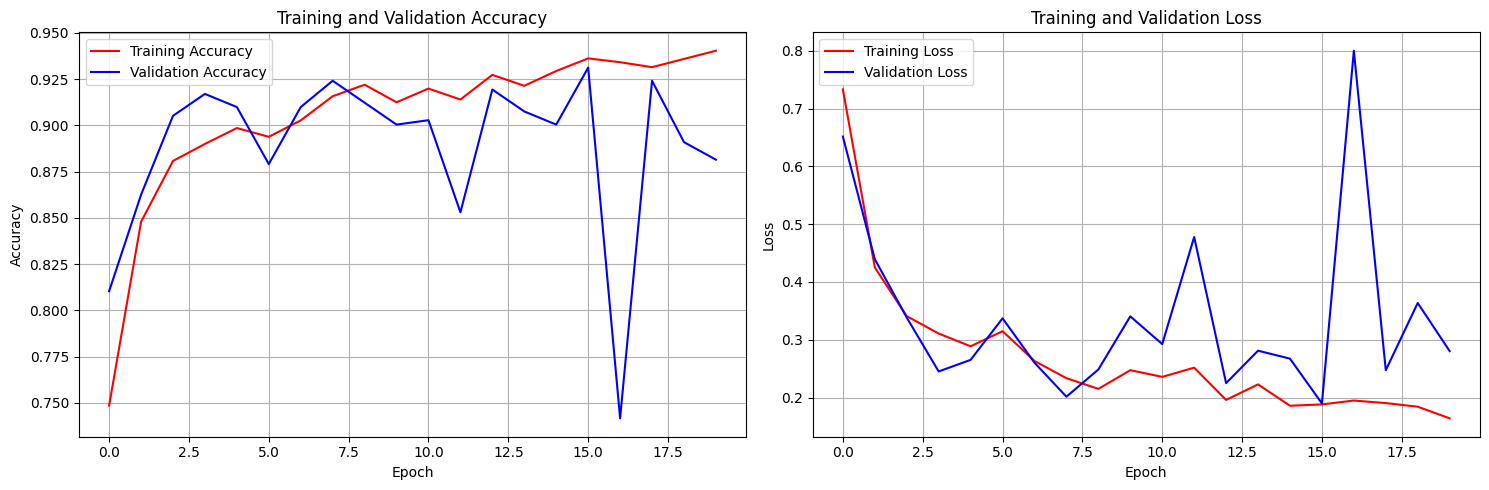

In [16]:

# Plot Accuracy
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [17]:
model.save('Model.h5')


In [21]:
model.save("model_katarak.keras")

In [22]:
import tensorflow as tf

# Load model Keras (pastikan sesuai dengan nama file kamu)
model = tf.keras.models.load_model("model_katarak.keras")

# Konversi ke TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# (Opsional) optimasi supaya ukuran file lebih kecil
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Jalankan konversi
tflite_model = converter.convert()

# Simpan hasil konversi
with open("model_katarak.tflite", "wb") as f:
    f.write(tflite_model)

print("✅ Model berhasil dikonversi ke model_katarak.tflite")


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 690 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Saved artifact at '/tmp/tmpszx92im7'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  136135741866832: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  136135741870864: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  136138183927440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136135564308560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136135564308944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136135564306640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136135564310672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136135737263312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136135737262352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136135737262928: TensorSpec(shape=(), dtype=tf.resource, name=Non

In [18]:
from tensorflow.keras.models import load_model
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load the model
model = load_model("Model.h5")

# Define the class names
class_names = ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

# Load an image from the test set
img = load_img("dataset/cataract/cataract_032.png", target_size=(224, 224))

# Convert the image to an array
img_array = img_to_array(img)
print(img_array)

print(img_array.shape)

img_array = np.reshape(img_array, (1, 224, 224, 3))

# Get the model predictions
predictions = model.predict(img_array)
print("predictions:", predictions)

# Get the class index with the highest predicted probability
class_index = np.argmax(predictions[0])

# Get the predicted class label
predicted_label = class_names[class_index]

print("The image is predicted to be '{}'.".format(predicted_label))

[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [1. 0. 1.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [1. 0. 1.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[2. 1. 1.]
  [1. 0. 1.]
  [1. 1. 1.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [1. 0. 0.]]

 ...

 [[3. 0. 1.]
  [1. 1. 0.]
  [2. 0. 1.]
  ...
  [1. 1. 1.]
  [2. 1. 1.]
  [1. 0. 0.]]

 [[2. 0. 1.]
  [2. 0. 1.]
  [2. 0. 1.]
  ...
  [1. 0. 0.]
  [2. 0. 1.]
  [1. 1. 1.]]

 [[3. 0. 1.]
  [2. 0. 1.]
  [2. 0. 1.]
  ...
  [1. 0. 0.]
  [3. 0. 1.]
  [2. 1. 1.]]]
(224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
predictions: [[0.98293006 0.00302071 0.01211954 0.00192972]]
The image is predicted to be 'cataract'.


In [19]:
!pip freeze > requirements.txt

In [20]:
import tensorflow as tf
print(tf.__version__)


2.19.0
